## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.`
a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
len(df.query("landing_page == 'new_page' and group == 'control' or landing_page == 'old_page' and group == 'treatment' "))

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.`
a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index )
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 
a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'])]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(df2[df2.duplicated(['user_id'])].index, inplace=True)
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted


`4.`
a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
(df2.query("group == 'control'")['converted']==1).mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
(df2.query("group == 'treatment'")['converted']==1).mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

### **From the previous propability results**
#### There isn't a sufficient evidence to conclude that the new treatment page leads to more conversions as the probability of people received the new page is only **0.5** and the probabilty of an individual was in the control group (**0.120**) is greater than the probabilty of an individual was in the treatment group (**0.118**)

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

###                        **NULL hypotheses H0**
####                           **$p_{new}$ <=$p_{old}$**
####                          **$p_{new}$ - $p_{old}<=0$**
#####            ---------------------------------------------------------------------------------
###                    **ALTERNATIVE hypotheses H1**
####                                  **$p_{new}$ > $p_{old}$**
####                                **$p_{new}$ - $p_{old}$ > 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


In [19]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = len(df2[df2['group'] == 'treatment'])
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = len(df2[df2['group'] == 'control'])
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1, p_new,n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, p_old,n_old)
old_page_converted

array([0, 0, 0, ..., 0, 1, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
diff = (new_page_converted.sum()/n_new) - (old_page_converted.sum()/n_old)
diff

-0.00034648704146110487

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.binomial(1, p_new,n_new)
    old_page_converted = np.random.binomial(1, p_old,n_old)
    diff = (new_page_converted.sum()/n_new) - (old_page_converted.sum()/n_old)
    p_diffs.append(diff)

p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   15.,   116.,   578.,  1630.,  2754.,  2690.,  1558.,   545.,
          101.,    13.]),
 array([ -4.48272798e-03,  -3.57835119e-03,  -2.67397439e-03,
         -1.76959759e-03,  -8.65220795e-04,   3.91560021e-05,
          9.43532799e-04,   1.84790960e-03,   2.75228639e-03,
          3.65666319e-03,   4.56103999e-03]),
 <a list of 10 Patch objects>)

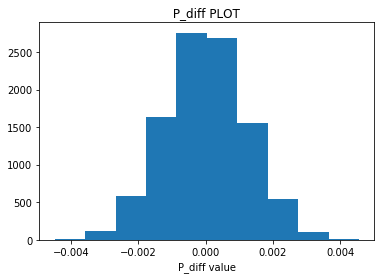

In [28]:
plt.xlabel('P_diff value')
plt.title(' P_diff PLOT ')
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
actual_treatment = df2.query('group == "treatment" and converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]
actual_control = df2.query('group == "control" and converted == 1').shape[0] / df2.query('group == "control"').shape[0]
actual_diff = actual_treatment - actual_control
actual_diff

-0.0015782389853555567

In [30]:
p_prop = (p_diffs > actual_diff).mean()
p_prop

0.90720000000000001

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

### *The calculated value is the P-value, The p-value is equal to "0.909" which is large so we fail to reject the null hypotheses, which means that the conversion rate of old page is better than the old page*

`1.` 

In [31]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1')['converted'].count()
convert_new = df2.query('landing_page == "new_page" and converted == 1')['converted'].count()
n_old = len(df2[df2['landing_page']=='old_page'])
n_new = len(df2[df2['landing_page']=='new_page'])
convert_old, convert_new, n_new , n_old

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145310, 145274)

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='larger')
z_score, p_value

(1.3109241984234394, 0.094941687240975514)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

### *From p-value (0.905) and z-score(1.31) which is a numerical measurement that describes a value's relationship to the mean we found that the conversions of old page is gtreater than the conversions of the new page so we fail to reject the null hypotheses*
###  *The values from j (0.909) is almost equal to the values of k (0.905) so there is no difference between both of them* 

<a id='regression'></a>
### Part III - A regression approach

`1.`
a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

### *Logistic Regression should be used as we only have 1's and 0's*

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [34]:
df2.drop('control', axis = 1, inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
lr = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lr.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-07 12:50 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

#### The p-value of ab_page is 0.1899 which means ab_page isn't statistcally significant as its value is greater than 0.05 
#### This part differs from part II, in part II it was a one sided while this part is two sided

### part  II
####  *NULL hypotheses H0:*                  $p_{new}$ <=$p_{old}$
#### *ALTERNATIVE hypotheses H1:*    $p_{new}$ > $p_{old}$

### part III
#### *NULL hypotheses H0:*                     $p_{new}$ = $p_{old}$
#### *ALTERNATIVE hypotheses H1:*      $p_{new}$ != $p_{old}$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### *Adding other factors is important as some features affect the conversion rate and enhance the performance of the model* 
#### *We may add some features not effective to the model causing misleading results*

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  

In [37]:
df_countries = pd.read_csv('countries.csv')
df_total = pd.merge(df2, df_countries, how = 'outer')
df_total.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [38]:
df_total['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [39]:
df_total[['CA','UK', 'US']] = pd.get_dummies(df_total['country'])
df_total.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [40]:
lr = sm.Logit(df_total['converted'], df_total[['intercept', 'CA','UK']])
result = lr.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-07 12:50 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

### *According to the p-values from the summary "0.1291 and 0.4558" are greater than 0.05 so the countries are not statistically significant, therefore countries doesn't have an impact on the conversion rate*

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
lr = sm.Logit(df_total['converted'], df_total[['intercept', 'CA','UK', 'ab_page']])
result = lr.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-07 12:50 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

In [42]:
df_total['CA_new'] = df_total['CA'] * df_total['ab_page']
df_total['UK_new'] = df_total['UK'] * df_total['ab_page']
df_total.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_new,UK_new
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [43]:
lr0 = sm.Logit(df_total['converted'], df_total[['intercept', 'CA', 'UK', 'ab_page', 'CA_new', 'UK_new']])
results = lr0.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-07 12:51 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA_new       -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_new        0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

<a id='conclusions'></a>
## Conclusion
### *From the previous results we fail to reject the null hypotheses so the alternative hypotheses is rejected as the conversion rate is very small, Therefore the old page will not be changed to the new page* 

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0